In [91]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import torch.nn as nn
import matplotlib
import torch as tc
import utils
from glob import glob
from evaluation import klx
from evaluation import mse
from evaluation.pse import power_spectrum_error, power_spectrum_error_per_dim
from bptt import models
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr
from torch import optim
from bptt import dataset
import main_eval
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
%matplotlib inline
import pickle

In [92]:
def load_model(model_id):
    model = models.Model()
    model.init_from_model_path(model_id)
    model.eval()
    return model
def is_model_id(path):
    """Check if path ends with a three digit, e.g. save/test/001 """
    run_nr = path.split('/')[-1]
    three_digit_numbers = {str(digit).zfill(3) for digit in set(range(1000))}
    return run_nr in three_digit_numbers
def get_model_ids(path):
    """
    Get model ids from a directory by recursively searching all subdirectories for files ending with a number
    """
    assert os.path.exists(path)
    if is_model_id(path):
        model_ids = [path]
    else:
        all_subfolders = glob(os.path.join(path, '**/*'), recursive=True)
        model_ids = [file for file in all_subfolders if is_model_id(file)]
    assert model_ids, 'could not load from path: {}'.format(path)
    return model_ids



def load_model(model_id):
    model = models.Model()
    model.init_from_model_path(model_id)
    model.eval()
    return model
def is_model_id(path):
    """Check if path ends with a three digit, e.g. save/test/001 """
    run_nr = path.split('/')[-1]
    three_digit_numbers = {str(digit).zfill(3) for digit in set(range(1000))}
    return run_nr in three_digit_numbers
def get_model_ids(path):
    """
    Get model ids from a directory by recursively searching all subdirectories for files ending with a number
    """
    assert os.path.exists(path)
    if is_model_id(path):
        model_ids = [path]
    else:
        all_subfolders = glob(os.path.join(path, '**/*'), recursive=True)
        model_ids = [file for file in all_subfolders if is_model_id(file)]
    assert model_ids, 'could not load from path: {}'.format(path)
    return model_ids





In [93]:
### Get working directory and set color scheme
work_dir = os.getcwd()
color_lstm = "#103161"
color_rnn ="#1A52A1"
color_plrnn ="#2574E1"

In [94]:
### Load models
def load_RNN(path):
    
    if path.find("MackeyGlass") !=-1 or path.find("EEG") !=-1: 
        KLX = pd.read_csv(path+"/eval/klz.csv",delimiter="\t")
        klx = np.array(list(KLX['klz_mc'].values))

    else:


        KLX = pd.read_csv(path+"/eval/klx.csv",delimiter="\t")
        klx = np.array(list(KLX['klx'].values))



    PSE = pd.read_csv(path+"/eval/pse.csv",delimiter="\t")

    HLD = pd.read_csv(path+"/eval/hellinger/pse.csv",delimiter="\t")






    key = KLX['Unnamed: 0']
    
    klx_avg_RNN = {}
    klx_sem_RNN = {}

    pse = np.array(list(PSE['mean'].values))
    pse_avg_RNN = {}
    pse_sem_RNN = {}
    
    hld = np.array(list(HLD['mean'].values))
    hld_avg_RNN = {}
    hld_sem_RNN = {}
    gamma = np.zeros_like(key)
    for k in range(len(key)):
        i=int(key[k].find("Gamma"))
        if key[k][i+5:i+9]=="1000":
            gamma[k] = 1000.   
        elif key[k][i+5:i+8]=='100':
            gamma[k] = 100.
        elif key[k][i+5:i+8]=='130':
            gamma[k] = 130.
        elif key[k][i+5:i+8]=='150':
            gamma[k] = 150.
        elif key[k][i+5:i+8]=='160':
            gamma[k] = 160.
        elif key[k][i+5:i+8]=='200':
            gamma[k] = 200.
        elif key[k][i+5:i+8]=='500':
            gamma[k] = 500.   
        elif key[k][i+5:i+7]=='05':
            gamma[k] = 5.

        else:
            gamma[k]=float(key[k][i+5:i+7])
    for g in np.unique(gamma):
        if g>1000:continue

        klx_avg_RNN[g]=np.nanmean(klx[gamma==g])
        klx_sem_RNN[g]=sem(klx[gamma==g])

        pse_avg_RNN[g]=np.nanmean(pse[gamma==g])
        pse_sem_RNN[g]=sem(pse[gamma==g])
        
        hld_avg_RNN[g]=np.nanmean(hld[gamma==g])
        hld_sem_RNN[g]=sem(hld[gamma==g])
        
    return [klx_avg_RNN, klx_sem_RNN, pse_avg_RNN, pse_sem_RNN,hld_avg_RNN,hld_sem_RNN]





In [95]:
### Load models for comparison with gradient clipping
def load_clipped(path):

    KLX = pd.read_csv(path+"/klx.csv",delimiter="\t")
    PSE = pd.read_csv(path+"/pse.csv",delimiter="\t")
    HLD = pd.read_csv(path+"/hellinger/pse.csv",delimiter="\t")


    keys = KLX["Unnamed: 0"]
    klx = np.array(list(KLX['klx'].values))
    pse = np.array(list(PSE['mean'].values))
    hld = np.array(list(HLD['mean'].values))


    klx_gradClip_LSTM=[]
    klx_gradClip_RNN=[]
    klx_gradClip_PLRNN=[]

    pse_gradClip_LSTM=[]
    pse_gradClip_RNN=[]
    pse_gradClip_PLRNN=[]

    hld_gradClip_LSTM=[]
    hld_gradClip_RNN=[]
    hld_gradClip_PLRNN=[]


    for key in keys:
        if key.find("Weather")!=-1 or key.find("Duffing")!=-1 :
            if True:#if key.find("sl250")!=-1 or key.find("seqlen200")!=-1:
                if key.find("LSTM")!=-1:
                    klx_gradClip_LSTM.append(klx[keys==key])
                    pse_gradClip_LSTM.append(pse[keys==key])
                    hld_gradClip_LSTM.append(hld[keys==key])


                if key.find("RNN")!=-1:
                    klx_gradClip_RNN.append(klx[keys==key])
                    pse_gradClip_RNN.append(pse[keys==key])
                    hld_gradClip_RNN.append(hld[keys==key])


                if key.find("PLRNN")!=-1:
                    klx_gradClip_PLRNN.append(klx[keys==key])
                    pse_gradClip_PLRNN.append(pse[keys==key])
                    hld_gradClip_PLRNN.append(hld[keys==key])


        else:
            if key.find("seqLen1000")!=-1:

                if key.find("LSTM_PLRNN")!=-1:
                    if (key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1):
                        klx_gradClip_LSTM.append(klx[keys==key])
                        pse_gradClip_LSTM.append(pse[keys==key])
                        hld_gradClip_LSTM.append(hld[keys==key])



                if key.find("RNN_PLRNN")!=-1:
                    if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1:
                        klx_gradClip_RNN.append(klx[keys==key])
                        pse_gradClip_RNN.append(pse[keys==key])
                        hld_gradClip_RNN.append(hld[keys==key])


                if key.find("PLRNN_PLRNN")!=-1:
                    if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1 :
                        klx_gradClip_PLRNN.append(klx[keys==key])
                        pse_gradClip_PLRNN.append(pse[keys==key])
                        hld_gradClip_PLRNN.append(hld[keys==key])


    klx_gradClip_LSTM = np.nanmean(klx_gradClip_LSTM)
    klx_gradClip_RNN = np.nanmean(klx_gradClip_RNN)
    klx_gradClip_PLRNN = np.nanmean(klx_gradClip_PLRNN)
    
    pse_gradClip_LSTM = np.nanmean(pse_gradClip_LSTM)
    pse_gradClip_RNN = np.nanmean(pse_gradClip_RNN)
    pse_gradClip_PLRNN = np.nanmean(pse_gradClip_PLRNN)

    hld_gradClip_LSTM = np.nanmean(hld_gradClip_LSTM)
    hld_gradClip_RNN = np.nanmean(hld_gradClip_RNN)
    hld_gradClip_PLRNN = np.nanmean(hld_gradClip_PLRNN)



    return [klx_gradClip_LSTM,klx_gradClip_RNN,klx_gradClip_PLRNN, \
    pse_gradClip_LSTM,pse_gradClip_RNN,pse_gradClip_PLRNN,\
    hld_gradClip_LSTM,hld_gradClip_RNN,hld_gradClip_PLRNN]

In [96]:
### Plotting pipe-pipeline
def plot_figures(LSTM_list,RNN_list,PLRNN_list,clipped_list,measure=['klx','pse','hld'],clipping=True,klz=False,save=None,args={'tau':111.111*np.log(2),'xlim':401,'ylim_klx':15.5,'legend':True},xticks=None):
    font = {'family' : 'Palatino',
        'weight' : 'normal',
        'size'   : 20}
    matplotlib.rc('font', **font)
   
    matplotlib.rc('text', usetex=True)
    #matplotlib.rcParams['text.latex.preamble'] = [r'\math']
    
    tau = args['tau']
    xlim = args['xlim']
    ylim = args['ylim']
    print(xlim)
    legend = args['legend']
    if 'klx' in measure:
        fig, ax = plt.subplots()
        plt.errorbar(RNN_list[0].keys(),RNN_list[0].values(),fmt='-',yerr=RNN_list[1].values(),label="RNN",color=color_rnn,marker="o",linewidth=2.5,markersize=8)
        plt.errorbar(PLRNN_list[0].keys(),PLRNN_list[0].values(),fmt='-',yerr=PLRNN_list[1].values(),label="PLRNN",color=color_plrnn,marker="s",linewidth=2.5,markersize=8)
        plt.errorbar(LSTM_list[0].keys(),LSTM_list[0].values(),fmt='-',yerr=LSTM_list[1].values(),label="LSTM",color=color_lstm,marker="v",linewidth=2.5,markersize=10)
        k = np.linspace(-10,15,1000)
        plt.plot(np.ones_like(k)*tau,k,'k-',linewidth=2.5) #label="$ln(2)/\lambda_{\max}$"
        if clipping:
            plt.plot(LSTM_list[0].keys(),clipped_list[0]*np.ones_like(list(LSTM_list[0].keys())),'--',linewidth=2.5,color="#004175")
            plt.plot(RNN_list[0].keys(),clipped_list[1]*np.ones_like(list(RNN_list[0].keys())),'--',linewidth=2.5,color="#0187F6")
            plt.plot(PLRNN_list[0].keys(),clipped_list[2]*np.ones_like(list(PLRNN_list[0].keys())),'--',linewidth=2.5,color="#4AA9F7")

        plt.ylabel("${D_{stsp}}$")
        plt.xlabel("learning interval $\\tau$")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.label.set_size(30)
        ax.xaxis.label.set_size(25)
        if xlim < 300:
            plt.xticks([tau,100,200],["$\\tau_{pred}$",100,200])

        elif xlim<500:
            plt.xticks([tau,200,400],["$\\tau_{pred}$",200,400])
        else:
            plt.xticks([tau,200,500,1000],["$\\tau_{pred}$",200,500,1000])
        plt.xlim(0,xlim)
        plt.ylim(0,ylim)
        if legend=='klx':
            plt.legend(frameon=False,prop={'size': 17})
        if klz:
            plt.ylim(10**-2.3,ylim)
            plt.semilogy()
        plt.tight_layout()
        if save!=None:
            plt.savefig(save+"_klx.pdf",dpi=600)

    if 'pse' in measure:
        fig, ax = plt.subplots()
        plt.errorbar(RNN_list[2].keys(),RNN_list[2].values(),fmt='-',yerr=RNN_list[3].values(),label="RNN",color=color_rnn,marker="o",linewidth=2.5,markersize=8)
        plt.errorbar(PLRNN_list[2].keys(),PLRNN_list[2].values(),fmt='-',yerr=PLRNN_list[3].values(),label="PLRNN",color=color_plrnn,marker="s",linewidth=2.5,markersize=8)
        plt.errorbar(LSTM_list[2].keys(),LSTM_list[2].values(),fmt='-',yerr=LSTM_list[3].values(),label="LSTM",color=color_lstm,marker="v",linewidth=2.5,markersize=10)
        k = np.linspace(-10,15,1000)
        plt.plot(np.ones_like(k)*tau,k,'k-',linewidth=2.5) #label="$ln(2)/\lambda_{\max}$"
        if clipping:
            plt.plot(LSTM_list[2].keys(),clipped_list[3]*np.ones_like(list(LSTM_list[2].keys())),'--',linewidth=2.5,color=color_lstm)
            plt.plot(RNN_list[2].keys(),clipped_list[4]*np.ones_like(list(RNN_list[2].keys())),'--',linewidth=2.5,color=color_rnn)
            plt.plot(PLRNN_list[2].keys(),clipped_list[5]*np.ones_like(list(PLRNN_list[2].keys())),'--',linewidth=2.5,color=color_plrnn)

        plt.ylabel("${PSC}$")
        plt.xlabel("learning interval $\\tau$")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.label.set_size(30)
        ax.xaxis.label.set_size(25)

        if xlim < 300:
            plt.xticks([tau,100,200],["$\\tau_{pred}$",100,200])

        elif xlim<500:
            plt.xticks([tau,200,400],["$\\tau_{pred}$",200,400])
        else:
            plt.xticks([tau,200,500,1000],["$\\tau_{pred}$",200,500,1000])
        plt.xlim(0,xlim)
        plt.ylim(-0.1,1.1)

        if legend=='pse' or legend==True:
            plt.legend(frameon=False,prop={'size': 17})
    
        plt.ylabel("${PSC}$")
        plt.tight_layout()
        if save!=None:
            plt.savefig(save+"_psc.pdf",dpi=600)

    if 'hld' in measure:
        fig, ax = plt.subplots()
        plt.errorbar(RNN_list[4].keys(),RNN_list[4].values(),fmt='-',yerr=RNN_list[5].values(),label="RNN",color=color_rnn,marker="o",linewidth=2.5,markersize=8)
        plt.errorbar(PLRNN_list[4].keys(),PLRNN_list[4].values(),fmt='-',yerr=PLRNN_list[5].values(),label="PLRNN",color=color_plrnn,marker="s",linewidth=2.5,markersize=8)
        plt.errorbar(LSTM_list[4].keys(),LSTM_list[4].values(),fmt='-',yerr=LSTM_list[5].values(),label="LSTM",color=color_lstm,marker="v",linewidth=2.5,markersize=10)
        k = np.linspace(-10,15,1000)
        plt.plot(np.ones_like(k)*tau,k,'k-',linewidth=2.5) #label="$ln(2)/\lambda_{\max}$"
        if clipping:
            plt.plot(LSTM_list[4].keys(),clipped_list[6]*np.ones_like(list(LSTM_list[4].keys())),'--',linewidth=2.5,color=color_lstm)
            plt.plot(RNN_list[4].keys(),clipped_list[7]*np.ones_like(list(RNN_list[4].keys())),'--',linewidth=2.5,color=color_rnn)
            plt.plot(PLRNN_list[4].keys(),clipped_list[8]*np.ones_like(list(PLRNN_list[4].keys())),'--',linewidth=2.5,color=color_plrnn)

        plt.ylabel("$D_H$")
        plt.xlabel("learning interval $\\tau$")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.label.set_size(30)
        ax.xaxis.label.set_size(25)
        if xlim < 300:
            plt.xticks([tau,100,200],["$\\tau_{pred}$",100,200])

        elif xlim<500:
            plt.xticks([tau,200,400],["$\\tau_{pred}$",200,400])
        else:
            plt.xticks([tau,200,500,1000],["$\\tau_{pred}$",200,500,1000])
        plt.xlim(0,xlim)
        plt.ylim(-0.1,1.1)

        if legend == "hld" or legend==True:
            plt.legend(frameon=False,prop={'size': 17})
    
        plt.tight_layout()
        if save!=None:
            plt.savefig(save+"_hld.pdf",dpi=600)
        plt.show()



#### Rössler plots

705


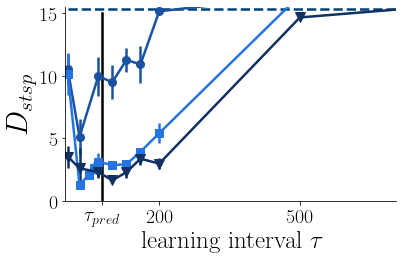

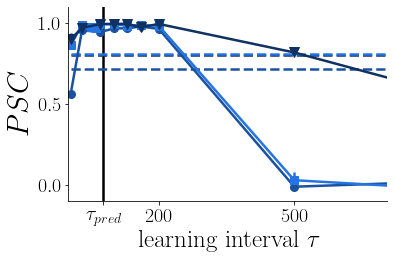

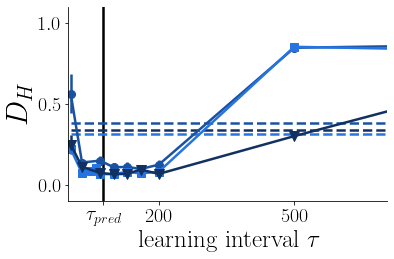

In [97]:

path = work_dir+ "/results" + "/Rössler"
klx_avg_RNN_Rossler,klx_sem_RNN_Rossler ,pse_avg_RNN_Rossler, \
pse_sem_RNN_Roessler, hld_avg_RNN_Rossler ,hld_sem_RNN_Roessler = load_RNN(path+"/RNN")
rossler_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_Rossler,klx_sem_LSTM_Rossler ,pse_avg_LSTM_Rossler, \
pse_sem_LSTM_Rossler, hld_avg_LSTM_Rossler ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

rossler_LSTM_list = load_RNN(path+"/LSTM")



klx_avg_PLRNN_Rossler,klx_sem_PLRNN_Rossler ,pse_avg_PLRNN_Rossler, \
pse_sem_PLRNN_Roessler, hld_avg_PLRNN_Rossler ,hld_sem_PLRNN_Rossler = load_RNN(path+"/PLRNN")

rossler_PLRNN_list = load_RNN(path+"/PLRNN")




rossler_clipped_list = load_clipped(path+"/gradientClipping/eval")

args={'tau':111.111*np.log(2),'xlim':705,'legend':False,'ylim':15.5}
save = work_dir+ '/figures/Roessler/Rössler'



plot_figures(rossler_LSTM_list,rossler_RNN_list,rossler_PLRNN_list,rossler_clipped_list,args=args,save=save)

#### Lorenz plots

{5.0: 4.358997029999999, 30.0: 0.06177164079999999, 50.0: 0.191398898, 60.0: 0.414861944, 70.0: 1.3381261260000001, 100.0: 9.33603016, 200.0: 12.0628274, 500.0: 9.03384866, 1000.0: 7.76472744} {5.0: 2.075628611909393, 30.0: 0.006535967102184665, 50.0: 0.04409770241595523, 60.0: 0.03412652137212898, 70.0: 0.19206759601421103, 100.0: 1.4676553504137138, 200.0: 1.4142149311317072, 500.0: 1.7532026438241577, 1000.0: 0.4050716112874717}
205


<ipython-input-95-c3905edc7dc6>:76: RuntimeWarning: Mean of empty slice
  klx_gradClip_PLRNN = np.nanmean(klx_gradClip_PLRNN)
<ipython-input-95-c3905edc7dc6>:80: RuntimeWarning: Mean of empty slice
  pse_gradClip_PLRNN = np.nanmean(pse_gradClip_PLRNN)
<ipython-input-95-c3905edc7dc6>:84: RuntimeWarning: Mean of empty slice
  hld_gradClip_PLRNN = np.nanmean(hld_gradClip_PLRNN)


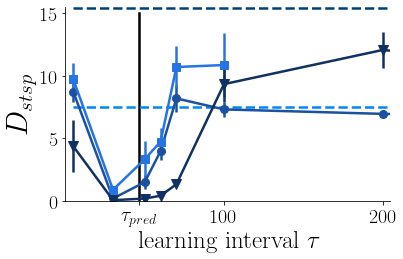

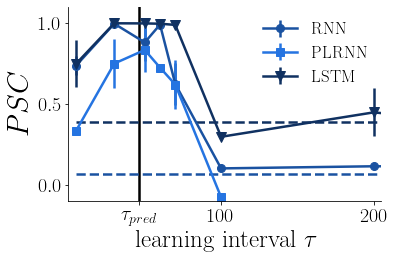

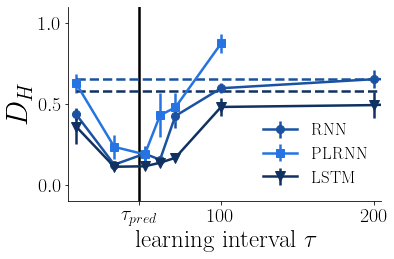

In [98]:


path = work_dir+ "/results" + "/Lorenz"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/PLRNN")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")

print(klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz)





lorenz_clipped_list = load_clipped(path+"/gradientClipping/eval")
save = work_dir+ '/figures/Lorenz/Lorenz'



args={'tau':66.667*np.log(2),'xlim':205,'legend':True,'ylim':15.5}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,save=save)

#### Windowing

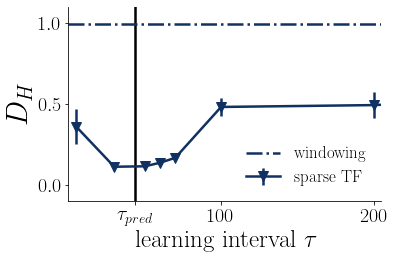

In [16]:
fig, ax = plt.subplots()
xlim = 205
tau= 62.5*np.log(2)
legend = True
LSTM_list = lorenz_LSTM_list
plt.errorbar(LSTM_list[4].keys(),LSTM_list[4].values(),fmt='-',yerr=LSTM_list[5].values(),label="sparse TF",color=color_lstm,marker="v",linewidth=2.5,markersize=10)
k = np.linspace(-10,15,1000)
plt.plot(np.ones_like(k)*tau,k,'k-',linewidth=2.5) 
###see file for the values below. The numbers were read in by copying because of convenience 
windowing_hld =np.mean(np.array([0.9973269034523101,0.9974160085283841, 0.9939602001085005]))
k_ = np.linspace(0,xlim,1000)
plt.plot(k_,np.ones_like(k_)*windowing_hld,"-.",color=color_lstm,linewidth=2.5,label="windowing") 


plt.ylabel("$D_H$")
plt.xlabel("learning interval $\\tau$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
if xlim < 300:
    plt.xticks([tau,100,200],["$\\tau_{pred}$",100,200])

elif xlim<500:
    plt.xticks([tau,200,400],["$\\tau_{pred}$",200,400])
else:
    plt.xticks([tau,200,500,1000],["$\\tau_{pred}$",200,500,1000])
plt.xlim(0,xlim)
plt.ylim(-0.1,1.1)

if legend == "hld" or legend==True:
    plt.legend(frameon=False,prop={'size': 17})

plt.tight_layout()
save = work_dir+ '/figures/Windowing/Windowing'


plt.savefig(save+"_hld.pdf",dpi=600)
plt.show()

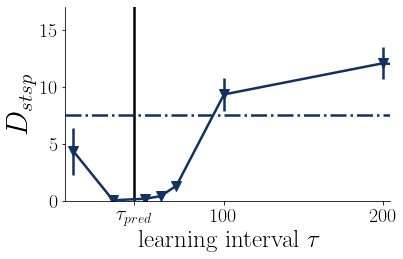

In [17]:
fig, ax = plt.subplots()
xlim = 205
tau= 62.5*np.log(2)
legend = False
LSTM_list = lorenz_LSTM_list
plt.errorbar(LSTM_list[0].keys(),LSTM_list[0].values(),fmt='-',yerr=LSTM_list[1].values(),label="LSTM",color=color_lstm,marker="v",linewidth=2.5,markersize=10)
k = np.linspace(-10,17,1000)
plt.plot(np.ones_like(k)*tau,k,'k-',linewidth=2.5) 
windowing_hld =np.mean(np.array([7.702925682067871,7.702925682067871, 7.182072639465332]))
k_ = np.linspace(0,xlim,1000)
plt.plot(k_,np.ones_like(k_)*windowing_hld,"-.",color=color_lstm,linewidth=2.5) 


plt.ylabel("$D_{stsp}$")
plt.xlabel("learning interval $\\tau$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
if xlim < 300:
    plt.xticks([tau,100,200],["$\\tau_{pred}$",100,200])

elif xlim<500:
    plt.xticks([tau,200,400],["$\\tau_{pred}$",200,400])
else:
    plt.xticks([tau,200,500,1000],["$\\tau_{pred}$",200,500,1000])
plt.xlim(0,xlim)
plt.ylim(0,17)

if legend == "hld" or legend==True:
    plt.legend(frameon=False,prop={'size': 17})

plt.tight_layout()
save = work_dir+ '/figures/Windowing/Windowing'


plt.savefig(save+"_klx.pdf",dpi=600)
plt.show()

#### Temperature data



205


<ipython-input-6-d30ce8285b00>:64: RuntimeWarning: Mean of empty slice
  pse_avg_RNN[g]=np.nanmean(pse[gamma==g])


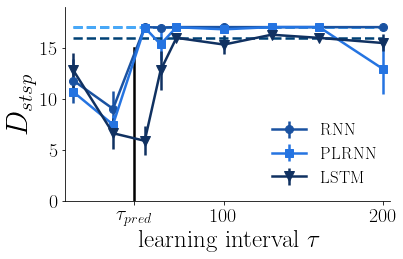

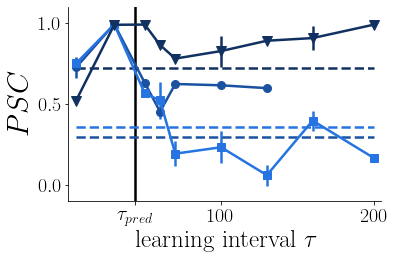

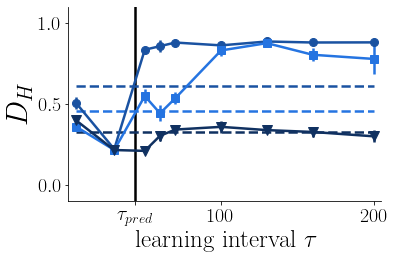

In [19]:



path = work_dir+ "/results" + "/Weather"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



#klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
#pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/vanillaPLRNN_noNorm/uniform")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")





lorenz_clipped_list = load_clipped(path+"/gradientClipping/eval")
save = work_dir+ '/figures/Weather/Weather'




args={'tau':62.5*np.log(2),'xlim':205,'legend':"klx",'ylim':19}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,save=save)

205


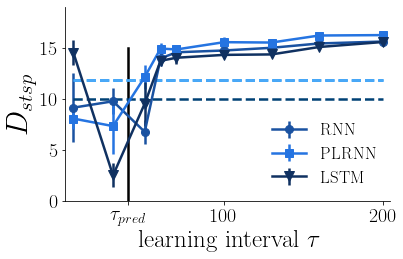

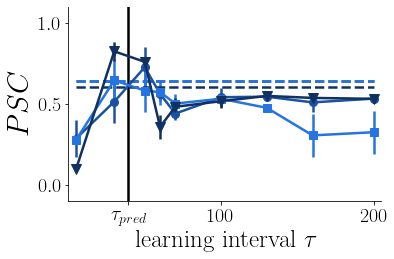

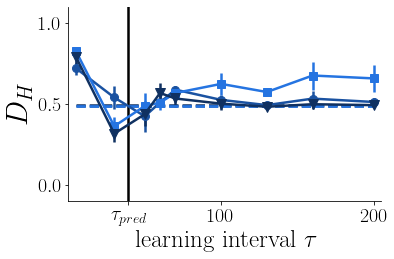

In [20]:


path = work_dir+ "/results" + "/Duffing"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



#klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
#pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/vanillaPLRNN_noNorm/uniform")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")



lorenz_clipped_list = load_clipped(path+"/gradientClipping/eval")
save = work_dir+ '/figures/Duffing/Duffing'




args={'tau':56.67*np.log(2),'xlim':205,'legend':"klx",'ylim':19}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,save=save)

205


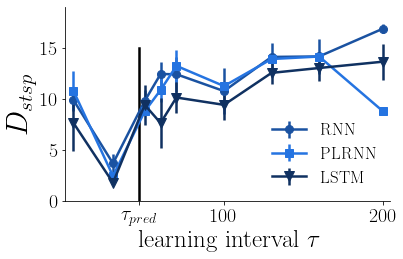

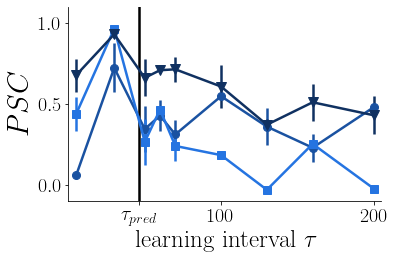

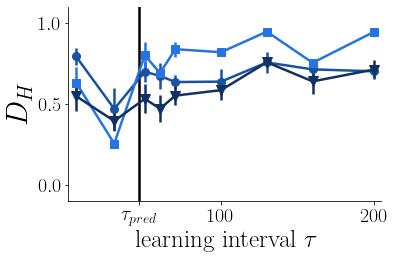

In [21]:


path = work_dir+ "/results" + "/Lorenz2D"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



#klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
#pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/vanillaPLRNN_noNorm/uniform")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")

save = work_dir+ '/figures/Lorenz2D/Lorenz2D'






#lorenz_clipped_list = load_clipped(path)

args={'tau':66.667*np.log(2),'xlim':205,'legend':"klx",'ylim':19}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,clipping=False,save=save)

<ipython-input-6-d30ce8285b00>:61: RuntimeWarning: Mean of empty slice
  klx_avg_RNN[g]=np.nanmean(klx[gamma==g])
<ipython-input-6-d30ce8285b00>:64: RuntimeWarning: Mean of empty slice
  pse_avg_RNN[g]=np.nanmean(pse[gamma==g])
<ipython-input-6-d30ce8285b00>:67: RuntimeWarning: Mean of empty slice
  hld_avg_RNN[g]=np.nanmean(hld[gamma==g])


205


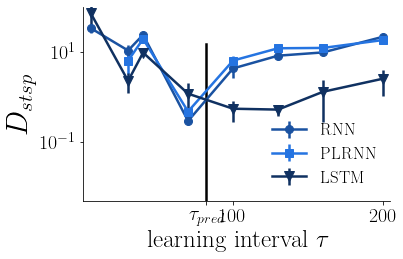

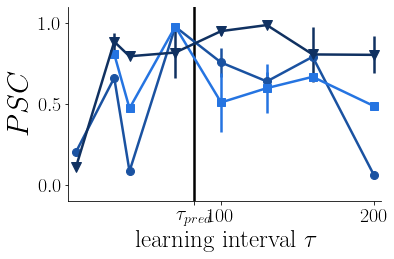

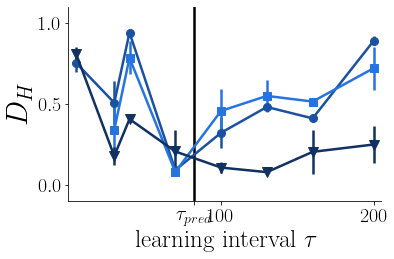

In [22]:


path = work_dir+ "/results" + "/MackeyGlass"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



#klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
#pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/vanillaPLRNN_noNorm/uniform")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")

save = work_dir+ '/figures/MackeyGlass/MackeyGlass'




#lorenz_clipped_list = load_clipped(path)

args={'tau':118.59*np.log(2),'xlim':205,'legend':"klx",'ylim':100}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,clipping=False,klz=True,save=save)

205


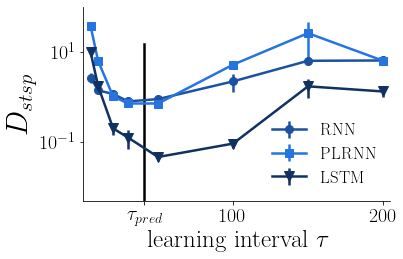

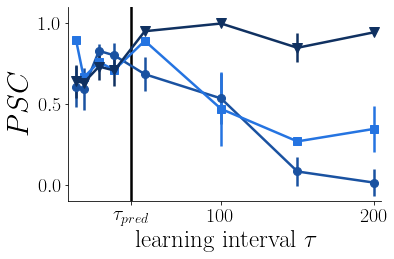

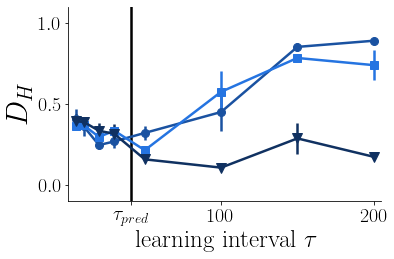

In [23]:


path = work_dir+ "/results" + "/EEG"


klx_avg_RNN_lorenz,klx_sem_RNN_lorenz ,pse_avg_RNN_lorenz, \
pse_sem_RNN_lorenz, hld_avg_RNN_lorenz ,hld_sem_RNN_lorenz = load_RNN(path+"/RNN")
lorenz_RNN_list = load_RNN(path+"/RNN")


klx_avg_LSTM_lorenz,klx_sem_LSTM_lorenz ,pse_avg_LSTM_lorenz, \
pse_sem_LSTM_lorenz, hld_avg_LSTM_lorenz ,hld_sem_LSTM_Roessler = load_RNN(path+"/LSTM")

lorenz_LSTM_list = load_RNN(path+"/LSTM")



#klx_avg_PLRNN_lorenz,klx_sem_PLRNN_lorenz ,pse_avg_PLRNN_lorenz, \
#pse_sem_PLRNN_lorenz, hld_avg_PLRNN_lorenz ,hld_sem_PLRNN_lorenz = load_RNN(path+"/vanillaPLRNN_noNorm/uniform")

lorenz_PLRNN_list = load_RNN(path+"/PLRNN")



save = work_dir+ '/figures/EEG/EEG'


args={'tau':58.82*np.log(2),'xlim':205,'legend':"klx",'ylim':100}
plot_figures(lorenz_LSTM_list,lorenz_RNN_list,lorenz_PLRNN_list,lorenz_clipped_list,args=args,clipping=False,klz=True,save=save)

Further comparisons
----

### Gradient Clipping

#### Max-clipping

[8.111508]
[8.451813]
[8.619156]


<ipython-input-29-6932277789fc>:95: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_LSTM,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm,label="LSTM")
<ipython-input-29-6932277789fc>:112: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_RNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_rnn,label="RNN")


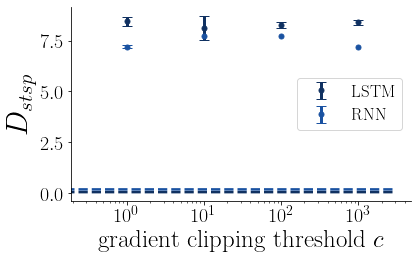

In [29]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
matplotlib.rc('text', usetex=True)
#path='/Users/jonas/Master/Theo_Neuroscience/ZI/BPTT/BPTT_training/results/Lorenz/gradientClipping/eval'
path=work_dir + '/results/GradClip/maxClip/Lorenz/eval'


KLX = pd.read_csv(path+"/klx.csv",delimiter="\t")
keys = KLX["Unnamed: 0"]
klx = np.array(list(KLX['klx'].values))
klx_gradClip_LSTM1=[]
klx_gradClip_RNN1=[]
klx_gradClip_PLRNN1=[]

klx_gradClip_LSTM10=[]
klx_gradClip_RNN10=[]
klx_gradClip_PLRNN10=[]

klx_gradClip_LSTM100=[]
klx_gradClip_RNN100=[]
klx_gradClip_PLRNN100=[]


klx_gradClip_LSTM1000=[]
klx_gradClip_RNN1000=[]
klx_gradClip_PLRNN1000=[]



for key in keys:
    if key.find("seqLen100")!=-1:
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM1.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN1.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1  and key.find("gc_1000")==-1 :
                klx_gradClip_PLRNN1.append(klx[keys==key])
                
for key in keys:
    if key.find("seqLen100")!=-1:
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM10.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN10.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1  :
                klx_gradClip_PLRNN10.append(klx[keys==key])
                
for key in keys:
    if key.find("seqLen100")!=-1 :
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM100.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN100.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_PLRNN100.append(klx[keys==key])
for key in keys:
    if key.find("seqLen100")!=-1 :
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_1000")!=-1:
                print(klx[keys==key])
                klx_gradClip_LSTM1000.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_1000")!=-1 and key.find("gc_01")==-1:
                klx_gradClip_RNN1000.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_1000")!=-1 and key.find("gc_01")==-1:
                klx_gradClip_PLRNN1000.append(klx[keys==key])
klx_gradClip_LSTM1 = np.array(klx_gradClip_LSTM1) 
klx_gradClip_LSTM10 = np.array(klx_gradClip_LSTM10)         
klx_gradClip_LSTM100 = np.array(klx_gradClip_LSTM100)         
klx_gradClip_LSTM1000 = np.array(klx_gradClip_LSTM1000)         


klx_gradClip_LSTM = np.empty((4,3,1))
klx_gradClip_LSTM[0]=klx_gradClip_LSTM1
klx_gradClip_LSTM[1]=klx_gradClip_LSTM10
klx_gradClip_LSTM[2]=klx_gradClip_LSTM100
klx_gradClip_LSTM[3]=klx_gradClip_LSTM1000


err = klx_gradClip_LSTM.std(axis=1)/np.sqrt(3)
plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_LSTM,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm,label="LSTM")


klx_gradClip_LSTM1 = np.array(klx_gradClip_RNN1) 
klx_gradClip_RNN10 = np.array(klx_gradClip_RNN10)         
klx_gradClip_RNN100 = np.array(klx_gradClip_RNN100)         
klx_gradClip_RNN1000 = np.array(klx_gradClip_RNN1000)         


klx_gradClip_RNN = np.empty((4,3,1))
klx_gradClip_RNN[0]=klx_gradClip_RNN1
klx_gradClip_RNN[1]=klx_gradClip_RNN10
klx_gradClip_RNN[2]=klx_gradClip_RNN100
klx_gradClip_RNN[3]=klx_gradClip_RNN1000


err = klx_gradClip_RNN.std(axis=1)/np.sqrt(3)
plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_RNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_rnn,label="RNN")

try:
    klx_gradClip_PLRNN1 = np.array(klx_gradClip_PLRNN1+ ['nan']+ ['nan']+ ['nan']) 
    klx_gradClip_PLRNN10 = np.array(klx_gradClip_PLRNN10 + ['nan']+ ['nan']+ ['nan'])        
    klx_gradClip_PLRNN100 = np.array(klx_gradClip_PLRNN100+ ['nan']+ ['nan']+ ['nan'])  
    klx_gradClip_PLRNN1000 = np.array(klx_gradClip_PLRNN1000+ ['nan'])         

    klx_gradClip_PLRNN = np.empty((4,3,1))
    klx_gradClip_PLRNN[0]=klx_gradClip_PLRNN1.reshape(3,1)
    klx_gradClip_PLRNN[1]=klx_gradClip_PLRNN10.reshape(3,1)
    klx_gradClip_PLRNN[2]=klx_gradClip_PLRNN100.reshape(3,1)
    klx_gradClip_PLRNN[3]=klx_gradClip_PLRNN1000.reshape(3,1)


    err = klx_gradClip_PLRNN.std(axis=1)/np.sqrt(3)
    print(klx_gradClip_PLRNN[2])
    plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_PLRNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_plrnn,label="PLRNN")
except ValueError:
    pass
plt.semilogx()

optimal_LSTM_avg = 0.06177164079999999
optimal_RNN_avg= 0.196466916
k_ = np.linspace(0,3000,10000)
plt.plot(k_,np.ones_like(k_)*optimal_LSTM_avg,"--",color=color_lstm,linewidth=2.5)#,label="LSTM: $\\tau_{opt}$") 
plt.plot(k_,np.ones_like(k_)*optimal_RNN_avg,"--",color=color_rnn,linewidth=2.5)#,label="RNN: $\\tau_{opt}$") 


#plt.xlim(10**-1.9,10**3.4)


plt.ylabel("${D_{stsp}}$")
#plt.xlabel("gradient clipping $c \geq (\partial \mathcal{L} / \partial \\theta )_i$")
plt.xlabel("gradient clipping threshold $c$" )#\geq||\partial \mathcal{L} / \partial \\theta ||$")


#ax.plot(range(10))
#plt.semilogx()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
plt.legend(frameon=True,prop={'size': 17})


plt.tight_layout()

save =work_dir+'/figures/GradClipping/'


plt.savefig(save+"max_clip_gc_seqLen1000_opt.pdf",dpi=600,format="pdf")




#### norm clipping

[8.202918]
[8.785827]
[13.851291]


<ipython-input-31-c8ad7387d396>:95: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_LSTM,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm,label="LSTM")
<ipython-input-31-c8ad7387d396>:112: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_RNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_rnn,label="RNN")
<ipython-input-31-c8ad7387d396>:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dt

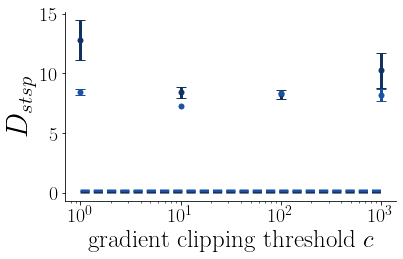

In [31]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
matplotlib.rc('text', usetex=True)
path=work_dir + '/results/GradClip/normClip/Lorenz/eval'



KLX = pd.read_csv(path+"/klx.csv",delimiter="\t")
keys = KLX["Unnamed: 0"]
klx = np.array(list(KLX['klx'].values))
klx_gradClip_LSTM1=[]
klx_gradClip_RNN1=[]
klx_gradClip_PLRNN1=[]

klx_gradClip_LSTM10=[]
klx_gradClip_RNN10=[]
klx_gradClip_PLRNN10=[]

klx_gradClip_LSTM100=[]
klx_gradClip_RNN100=[]
klx_gradClip_PLRNN100=[]


klx_gradClip_LSTM1000=[]
klx_gradClip_RNN1000=[]
klx_gradClip_PLRNN1000=[]



for key in keys:
    if key.find("seqLen100")!=-1:
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM1.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN1.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_01")!=-1 and key.find("gc_100")==-1 and key.find("gc_10")==-1  and key.find("gc_1000")==-1 :
                klx_gradClip_PLRNN1.append(klx[keys==key])
                
for key in keys:
    if key.find("seqLen100")!=-1:
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM10.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN10.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_10")!=-1 and key.find("gc_100")==-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1  :
                klx_gradClip_PLRNN10.append(klx[keys==key])
                
for key in keys:
    if key.find("seqLen100")!=-1 :
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_LSTM100.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_RNN100.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_100")!=-1 and key.find("gc_01")==-1 and key.find("gc_1000")==-1 :
                klx_gradClip_PLRNN100.append(klx[keys==key])
for key in keys:
    if key.find("seqLen100")!=-1 :
        if key.find("LSTM_PLRNN")!=-1:
            if key.find("gc_1000")!=-1:
                print(klx[keys==key])
                klx_gradClip_LSTM1000.append(klx[keys==key])
        if key.find("RNN_PLRNN")!=-1 and key.find("PLRNN_PLRNN")==-1:
            if key.find("gc_1000")!=-1 and key.find("gc_01")==-1:
                klx_gradClip_RNN1000.append(klx[keys==key])
        if key.find("PLRNN_PLRNN")!=-1:
            if key.find("gc_1000")!=-1 and key.find("gc_01")==-1:
                klx_gradClip_PLRNN1000.append(klx[keys==key])
klx_gradClip_LSTM1 = np.array(klx_gradClip_LSTM1) 
klx_gradClip_LSTM10 = np.array(klx_gradClip_LSTM10)         
klx_gradClip_LSTM100 = np.array(klx_gradClip_LSTM100)         
klx_gradClip_LSTM1000 = np.array(klx_gradClip_LSTM1000)         


klx_gradClip_LSTM = np.empty((4,3,1))
klx_gradClip_LSTM[0]=klx_gradClip_LSTM1
klx_gradClip_LSTM[1]=klx_gradClip_LSTM10
klx_gradClip_LSTM[2]=klx_gradClip_LSTM100
klx_gradClip_LSTM[3]=klx_gradClip_LSTM1000


err = klx_gradClip_LSTM.std(axis=1)/np.sqrt(3)
plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_LSTM,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm,label="LSTM")


klx_gradClip_LSTM1 = np.array(klx_gradClip_RNN1) 
klx_gradClip_RNN10 = np.array(klx_gradClip_RNN10)         
klx_gradClip_RNN100 = np.array(klx_gradClip_RNN100)         
klx_gradClip_RNN1000 = np.array(klx_gradClip_RNN1000)         


klx_gradClip_RNN = np.empty((4,3,1))
klx_gradClip_RNN[0]=klx_gradClip_RNN1
klx_gradClip_RNN[1]=klx_gradClip_RNN10
klx_gradClip_RNN[2]=klx_gradClip_RNN100
klx_gradClip_RNN[3]=klx_gradClip_RNN1000


err = klx_gradClip_RNN.std(axis=1)/np.sqrt(3)
plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_RNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_rnn,label="RNN")

try:
    klx_gradClip_PLRNN1 = np.array(klx_gradClip_PLRNN1+ ['nan']+ ['nan']+ ['nan']) 
    klx_gradClip_PLRNN10 = np.array(klx_gradClip_PLRNN10 + ['nan']+ ['nan']+ ['nan'])        
    klx_gradClip_PLRNN100 = np.array(klx_gradClip_PLRNN100+ ['nan'])  
    klx_gradClip_PLRNN1000 = np.array(klx_gradClip_PLRNN1000+ ['nan']+ ['nan'])         

    klx_gradClip_PLRNN = np.empty((4,3,1))
    klx_gradClip_PLRNN[0]=klx_gradClip_PLRNN1.reshape(3,1)
    klx_gradClip_PLRNN[1]=klx_gradClip_PLRNN10.reshape(3,1)
    klx_gradClip_PLRNN[2]=klx_gradClip_PLRNN100.reshape(3,1)
    klx_gradClip_PLRNN[3]=klx_gradClip_PLRNN1000.reshape(3,1)


    err = klx_gradClip_PLRNN.std(axis=1)/np.sqrt(3)
    print(klx_gradClip_PLRNN[2])
    plt.errorbar([1,10,100,1000],np.nanmean(klx_gradClip_PLRNN,axis=1),yerr=err.reshape(-1),fmt='.',linewidth=3,marker='o',markersize=5,capsize=5,color=color_plrnn,label="PLRNN")
except ValueError:
    pass
plt.semilogx()

optimal_LSTM_avg = 0.06177164079999999
optimal_RNN_avg= 0.196466916
k_ = np.linspace(1,10**5.5,10000)
k_ = np.linspace(1,10**3,10000)


plt.plot(k_,np.ones_like(k_)*optimal_LSTM_avg,"--",color=color_lstm,linewidth=2.5)#,label="LSTM: $\\tau_{opt}$") 
plt.plot(k_,np.ones_like(k_)*optimal_RNN_avg,"--",color=color_rnn,linewidth=2.5)#,label="RNN: $\\tau_{opt}$") 


#plt.xlim(10**-1,10**5.3)


plt.ylabel("${D_{stsp}}$")
#plt.xlabel("gradient clipping $c \geq||\partial \mathcal{L} / \partial \\theta ||$")
plt.xlabel("gradient clipping threshold $c$" )#\geq||\partial \mathcal{L} / \partial \\theta ||$")


#ax.plot(range(10))
#plt.semilogx()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
#plt.legend(frameon=True,prop={'size': 17},loc="lower left",bbox_to_anchor=(0.0, 0.1))


plt.tight_layout()

save =work_dir+'/figures/GradClipping/'


plt.savefig(save+"norm_clip_gc_seqLen1000_opt.pdf",dpi=600,format="pdf")





In [32]:
KLX = pd.read_csv(work_dir+"/results/Comparisons/Windowing/Lorenz/eval/klx.csv",delimiter="\t")




key = KLX['Unnamed: 0']

klx = np.array(list(KLX['klx'].values))
klx_avg_PLRNN = {}
klx_sem_PLRNN = {}
gamma = np.zeros_like(key)
for k in range(len(key)):
    i=int(key[k].find("seqLen"))
    if key[k][i+6:i+9]=='100':
        gamma[k] = 100.
    elif key[k][i+6:i+8]=='10':
        gamma[k] = 10.
    elif key[k][i+6:i+8]=='30':
        gamma[k] = 30.
    elif key[k][i+6:i+8]=='50':
        gamma[k] = 50.
    elif key[k][i+6:i+9]=='200':
        gamma[k] = 200.
    
for g in np.unique(gamma):
    #if g%10!=0:continue
   
    klx_avg_PLRNN[g]=np.nanmean(klx[gamma==g])
    klx_sem_PLRNN[g]=sem(klx[gamma==g][np.isfinite(klx[gamma==g])])

<ipython-input-35-b63a2b8f4e06>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(klx_avg_PLRNN.keys(),klx_avg_PLRNN.values(),yerr=klx_sem_PLRNN.values(),label="windowing",fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)


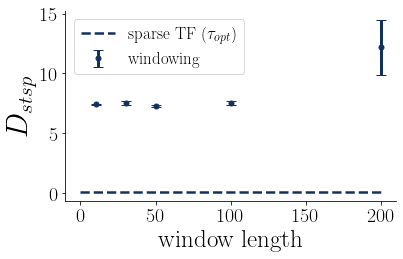

In [35]:
fig, ax = plt.subplots()
matplotlib.rc('text', usetex=True)


plt.errorbar(klx_avg_PLRNN.keys(),klx_avg_PLRNN.values(),yerr=klx_sem_PLRNN.values(),label="windowing",fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)
optimal_LSTM_avg = 0.06177164079999999
k_ = np.linspace(0,200,1000)
plt.plot(k_,np.ones_like(k_)*optimal_LSTM_avg,"--",color=color_lstm,linewidth=2.5,label="sparse TF ($\\tau_{opt}$)") 




plt.ylabel("${D_{stsp}}$")
plt.xlabel("window length")
#ax.plot(range(10))
#plt.semilogx()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
plt.legend(frameon=True,prop={'size': 17})


plt.tight_layout()

save =work_dir+'/figures/Windowing/'

plt.savefig(save+"windowing_sweep.pdf",dpi=600,format="pdf")




Randomly sparsely forced BPTT
----

In [37]:
path= work_dir+"/results/Comparisons/Random/Lorenz/eval"
KLX = pd.read_csv(path+"/klx.csv",delimiter="\t")

key = KLX['Unnamed: 0']

klx = np.array(list(KLX['klx'].values))
klx_avg_PLRNN = {}
klx_sem_PLRNN = {}
gamma = np.zeros_like(key)
for k in range(len(key)):
    i=int(key[k].find("dTau"))
    if key[k][i+4:i+7]=="100":
        gamma[k] = float(key[k][i+4:i+7])
    else:
        gamma[k] = float(key[k][i+4:i+6])
    
    
for g in np.unique(gamma):
    #if g%10!=0:continue
   
    klx_avg_PLRNN[g]=np.nanmean(klx[gamma==g])
    klx_sem_PLRNN[g]=sem(klx[gamma==g][np.isfinite(klx[gamma==g])])
print(klx_avg_PLRNN)

{10.0: 0.02073909833333333, 20.0: 0.09302940999999999, 30.0: 0.11020529666666667, 50.0: 8.126768333333333, 70.0: 8.786964800000002}


<ipython-input-38-63e7f5c31095>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(klx_avg_PLRNN.keys(),klx_avg_PLRNN.values(),yerr=klx_sem_PLRNN.values(),fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)
<ipython-input-38-63e7f5c31095>:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(1,mean_LSTM_avg,yerr=mean_LSTM_sem,label="LSTM",fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)


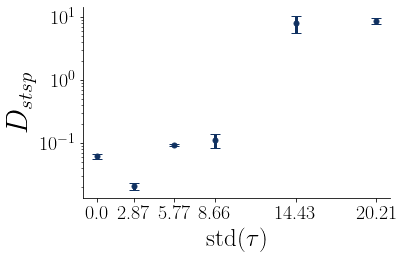

In [38]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
matplotlib.rc('text', usetex=True)
plt.errorbar(klx_avg_PLRNN.keys(),klx_avg_PLRNN.values(),yerr=klx_sem_PLRNN.values(),fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)
mean_LSTM_avg = 0.06177164079999999

mean_LSTM_sem= 0.006535967102184665
plt.errorbar(1,mean_LSTM_avg,yerr=mean_LSTM_sem,label="LSTM",fmt="o", linewidth=3,marker='o',markersize=5,capsize=5,color=color_lstm)
def unif_std(x):return np.sqrt((x**2-1)/12)

plt.xticks([1,10,20,30,50,70],[round(unif_std(x),2) for x in [1,10,20,30,50,70]])


plt.ylabel("${D_{stsp}}$")
plt.xlabel(" std$(\\tau$)")
#ax.plot(range(10))
plt.semilogy()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
#plt.legend(frameon=False,prop={'size': 17})


plt.tight_layout()

save =work_dir+'/figures/RandomTF/'

plt.savefig(save+"randomTF.pdf",dpi=600,format="pdf")



Gradients
----

Create simple 2-cycle as periodic toy-example

In [994]:
ts = np.empty((10000,2))
for i in range(10000):
    ts[i]=(-1)**i*np.array([1,1])
np.save("two_cylce.npy",ts)



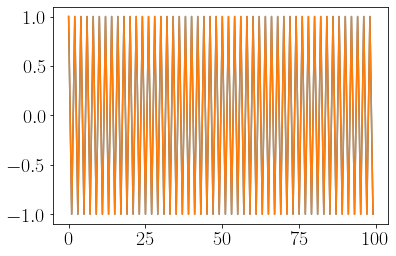

In [995]:
plt.plot(ts[:100])

Load gradients saved in training

In [42]:
### change to .../cycle_norm_bptt.pt for results on cycles instead of chaos
norm_bptt= tc.load(work_dir+"/results/gradientsInTraining/chaos_norm_bptt.pt").detach().numpy()
norm_spafo = tc.load(work_dir+"/results/gradientsInTraining/chaos_norm_spafo.pt").detach().numpy()



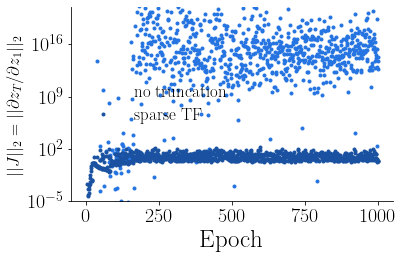

In [43]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
matplotlib.rc('text', usetex=True)
plt.plot(norm_bptt,linewidth=0,marker="o",color=color_plrnn,label="no truncation",markersize=3)

plt.plot(norm_spafo,linewidth=0,marker="o",color=color_rnn,label="sparse TF",markersize=3)



plt.semilogy()
#ax.set_ylim(10**(-1),10**21)
plt.ylim(10**-5,float(10**21))
#ax.set_yscale('symlog',linthreshy=1e-1)

plt.ylabel("$||J||_2 = ||\partial z_T / \partial z_1||_2$")
plt.xlabel("Epoch")
#ax.plot(range(10))
#plt.semilogx()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(17)
ax.xaxis.label.set_size(25)
plt.legend(frameon=False,prop={'size': 17})

#plt.yticks([0,1,10**3,10**6,10**10],["0","1","$10^3$","$10^6$","$10^{10}$"])


plt.tight_layout()

#save ='/Users/jonas/Master/Theo_Neuroscience/ZI/BPTT/BPTT_training/figures/Rebuttal/'

#plt.savefig(save+"chaos_gradients.pdf",dpi=600,format="pdf")




#### Gradients vs. T for PLRNN

In [100]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 27}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
#two working examples. Comment in the one you are interested in cycle/chaos for data and model_path


data_path= 'datasets/Lorenz/lorenz_data_chaos.npy'

data_path= 'datasets/two_cycle.npy'




data = tc.tensor(utils.read_data(data_path))

model_path = work_dir+'/results/Lorenz/PLRNN/Model_PLRNN_PLRNNb01z30Gamma30/003'
model_path = work_dir+'/results/GradientTests/Pendulum/029'

model_ids = get_model_ids(model_path)
model = load_model(*model_ids)
N = 30000
A,W,h = model.latent_model.get_latent_parameters()

M = 30000
ts,z= model.generate_free_trajectory(data,M+1)
ts = ts.detach()

d = tc.zeros_like(z)
d[z>=0] = 1

norms =[]
Nrange = np.logspace(1,4,100)
for N in Nrange:
    N=int(N)
    d = tc.zeros_like(z[M])
    d[z[M]>0] = 1
    prod = tc.diag(A) + tc.matmul(W,tc.diag(d))
    for i in range(1,N):
        d = tc.zeros_like(z[M-i])
        d[z[M-i]>0] = 1
        new = tc.diag(A)+tc.matmul(W,tc.diag(d))
        prod = tc.matmul(prod,new)
    #leig = np.max(np.linalg.eigvals(prod.detach()))
    #print(leig)
    try:
        norm = tc.linalg.norm(prod,ord=2)
        norms.append(norm.detach())
    except RuntimeError:
        
        norms.append(float('nan'))




no Layer Norm


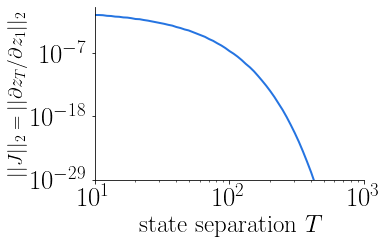

In [102]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 27}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
fig, ax = plt.subplots()


plt.plot(Nrange,norms,color=color_plrnn,linewidth=2)
plt.loglog()
#plt.semilogy()
plt.xlim(10,10**3)

### Include for gradients of cyclic RNN to not run out of computer precision
plt.ylim(10**-29,10)

plt.ylabel("$||J||_2 = ||\partial z_T / \partial z_1||_2$")
plt.xlabel("state separation $T$")
#ax.plot(range(10))
#plt.semilogx()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(25)
#plt.legend(frameon=False,prop={'size': 17})

#plt.yticks([0,1,10**3,10**6,10**10],["0","1","$10^3$","$10^6$","$10^{10}$"])

plt.tight_layout()

save =work_dir+'/figures/TheoremIllustration/'

plt.savefig(save+"cycle_gradients_vsT.pdf",dpi=600,format="pdf")



#### Reconstruction examples

/Users/jonas/miniforge3/envs/reg_plrnn/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/jonas/miniforge3/envs/reg_plrnn/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, y

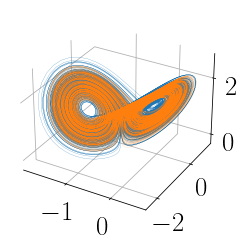

In [768]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 27}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
data_path= 'datasets/Lorenz/lorenz_data_chaos.npy'
#data_path= 'datasets/Roessler_chaos_rosenstein.npy'


data = tc.tensor(utils.read_data(data_path))
model_path =  '/Users/jonas/Master/Theo_Neuroscience/ZI/BPTT/BPTT_training/results/Lorenz/RNN/Model_RNNb01z30Gamma30/001'
#model_path= '/Users/jonas/Master/Theo_Neuroscience/ZI/BPTT/BPTT_training/results/Rebuttal/Windowing/Lorenz/lorenz_data_chaos.npyModel_LSTM_PLRNNz30Gamma01Gamma50seqLen100/003'

model_ids = get_model_ids(model_path)
model = load_model(*model_ids)
N = 30000


ts,z = model.generate_free_trajectory(data,30000)
ts = ts.detach()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:N,0],data[:N,1],data[:N,2],linewidth=0.2)
ax.plot(ts[:,0],ts[:,1],ts[:,2],linewidth=0.1)
value = 1
ax.w_xaxis.set_pane_color((value, value, value, value))
ax.w_yaxis.set_pane_color((value, value, value, value))
ax.w_zaxis.set_pane_color((value, value, value, value))
plt.savefig(save+"RNN_optimalTau.jpg",dpi=600,format="jpg")





### Annealing

In [73]:
path = work_dir+"/results/Comparisons/annealing/Lorenz"


KLX = pd.read_csv(path+"/eval/klx.csv",delimiter="\t")
klx = np.array(list(KLX['klx'].values))









key = KLX['Unnamed: 0']

klx_avg_RNN_ann = {}
klx_sem_RNN_ann = {}
klx_RNN  = {}
gamma = np.zeros_like(key)
for k in range(len(key)):
    i=int(key[k].find("Gamma"))
    if key[k][i+5:i+9]=="1000":
        gamma[k] = 1000.   
    elif key[k][i+5:i+8]=='100':
        gamma[k] = 100.
    elif key[k][i+5:i+8]=='130':
        gamma[k] = 130.
    elif key[k][i+5:i+8]=='150':
        gamma[k] = 150.
    elif key[k][i+5:i+8]=='160':
        gamma[k] = 160.
    elif key[k][i+5:i+8]=='200':
        gamma[k] = 200.
    elif key[k][i+5:i+8]=='500':
        gamma[k] = 500.   
    elif key[k][i+5:i+7]=='05':
        gamma[k] = 5.

    else:
        gamma[k]=float(key[k][i+5:i+7])
for g in np.unique(gamma):
    if g>1000:continue
    
    klx_avg_RNN_ann[g]=np.nanmean(klx[gamma==g])
    klx_sem_RNN_ann[g]=sem(klx[gamma==g])
    klx_RNN[g] = klx[gamma==g]
 


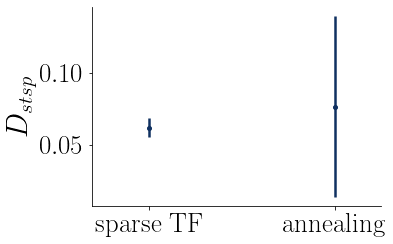

In [75]:
fig, ax = plt.subplots()
tau_opt = 0
lstm_opt = 0.06177164079999999
lstm_opt_sem = 0.006535967102184665
k = np.linspace(20,50,100)
plt.errorbar(30,lstm_opt,lstm_opt_sem,fmt= ".",color=color_lstm,linewidth=2.5,markersize=8)
#plt.plot(k,lstm_opt*np.ones_like(k),'--',color=color_lstm,label="optimal $\\tau_{pred}$")
plt.errorbar(klx_avg_RNN_ann.keys(),klx_avg_RNN_ann.values(),yerr= klx_sem_RNN_ann.values(),fmt= ".",color=color_lstm,linewidth=2.5,markersize=8)
plt.ylabel("${D_{stsp}}$")
#plt.xlabel("annealing end-point $\\tau_{end}$")
#ax.plot(range(10))
#plt.semilogy()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
#plt.legend(frameon=True,prop={'size': 17})
plt.xticks([30,46],["sparse TF","annealing"])
plt.xlim(25,50)
plt.tight_layout()

save =work_dir+'/figures/Annealing/'

plt.savefig(save+"annealing.pdf",dpi=600,format="pdf")



### Truncated BPTT

In [71]:

path = work_dir+"/results/Comparisons/truncBPTT/Lorenz"
KLX = pd.read_csv(path+"/eval/klx.csv",delimiter="\t")
klx = np.array(list(KLX['klx'].values))









key = KLX['Unnamed: 0']

klx_avg_RNN_ann = {}
klx_sem_RNN_ann = {}
klx_RNN  = {}
gamma = np.zeros_like(key)
for k in range(len(key)):
    i=int(key[k].find("Gamma"))
    if key[k][i+5:i+9]=="1000":
        gamma[k] = 1000.   
    elif key[k][i+5:i+8]=='100':
        gamma[k] = 100.
    elif key[k][i+5:i+8]=='130':
        gamma[k] = 130.
    elif key[k][i+5:i+8]=='150':
        gamma[k] = 150.
    elif key[k][i+5:i+8]=='160':
        gamma[k] = 160.
    elif key[k][i+5:i+8]=='200':
        gamma[k] = 200.
    elif key[k][i+5:i+8]=='500':
        gamma[k] = 500.   
    elif key[k][i+5:i+7]=='05':
        gamma[k] = 5.

    else:
        gamma[k]=float(key[k][i+5:i+7])
for g in np.unique(gamma):
    if g>1000:continue
    
    klx_avg_RNN_ann[g]=np.nanmean(klx[gamma==g])
    klx_sem_RNN_ann[g]=sem(klx[gamma==g])
    klx_RNN[g] = klx[gamma==g]
 



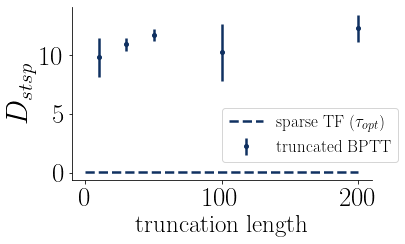

In [72]:
fig, ax = plt.subplots()
tau_opt = 0
plt.errorbar(klx_avg_RNN_ann.keys(),klx_avg_RNN_ann.values(),yerr= klx_sem_RNN_ann.values(),fmt= ".",color=color_lstm,linewidth=2.5,markersize=8,label="truncated BPTT")
plt.ylabel("${D_{stsp}}$")
plt.xlabel("truncation length")
optimal_LSTM_avg = 0.06177164079999999
k_ = np.linspace(0,200,1000)
plt.plot(k_,np.ones_like(k_)*optimal_LSTM_avg,"--",color=color_lstm,linewidth=2.5,label="sparse TF ($\\tau_{opt}$)") 



#ax.plot(range(10))
#plt.semilogy()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(25)
plt.legend(frameon=True,prop={'size': 17},loc=(0.5,0.1))


plt.tight_layout()

save =work_dir+'/figures/TruncatedBPTT/'

plt.savefig(save+"truncBPTT.pdf",dpi=600,format="pdf")


